# Load data

In [10]:
import xarray as xr

data_dir = 'D:/VScode/Last_deglaciation/data'
ds_sat = xr.open_dataset(data_dir + '/ds_sat_EOFs.nc')

# drop variables: sat_centered_weighted; EOF1 EOF2
ds_sat= ds_sat.drop(['sat_centered_weighted', 'EOF1', 'EOF2'])
ds_sat.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:       (age: 65, lat: 96, lon: 144)
Coordinates:
  * lat           (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon           (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * age           (age) float32 1.11e+04 1.13e+04 1.15e+04 ... 2.37e+04 2.39e+04
Data variables:
    sat           (age, lat, lon) float32 ...
    sat_std       (age, lat, lon) float32 ...
    sat_centered  (age, lat, lon) float32 ...
    weight        (lat) float32 ...>

# Sample the data for each latitude according to the weight of the latitude

In [29]:
import numpy as np
import xarray as xr


# 1. Compute the number of samples for each latitude
samples_per_lat = (len(ds_sat['lon']) * ds_sat['weight']).astype(int)
# samples_per_lat

# 2. For each latitude, sample x times from the sat_centered data
samples = []


# To store the chosen longitudes for each latitude
chosen_lons_list = []

for lat, num_samples in zip(ds_sat['lat'], samples_per_lat):
    if num_samples > 0:  
        chosen_lons = np.random.choice(ds_sat['lon'].values, int(num_samples), replace=False)
    else:
        chosen_lons = ds_sat['lon'].values
    
    # Store the chosen longitudes
    chosen_lons_list.append(chosen_lons)
    
    # Extract the corresponding sat_centered data for each chosen longitude
    sampled_data = ds_sat['sat_centered'].sel(lat=lat, lon=chosen_lons).values
    samples.append(sampled_data)
    

# 3. Convert the list of arrays into a single ndarray
sampled_array = np.concatenate(samples, axis=1)

print(sampled_array.shape)


(65, 8946)


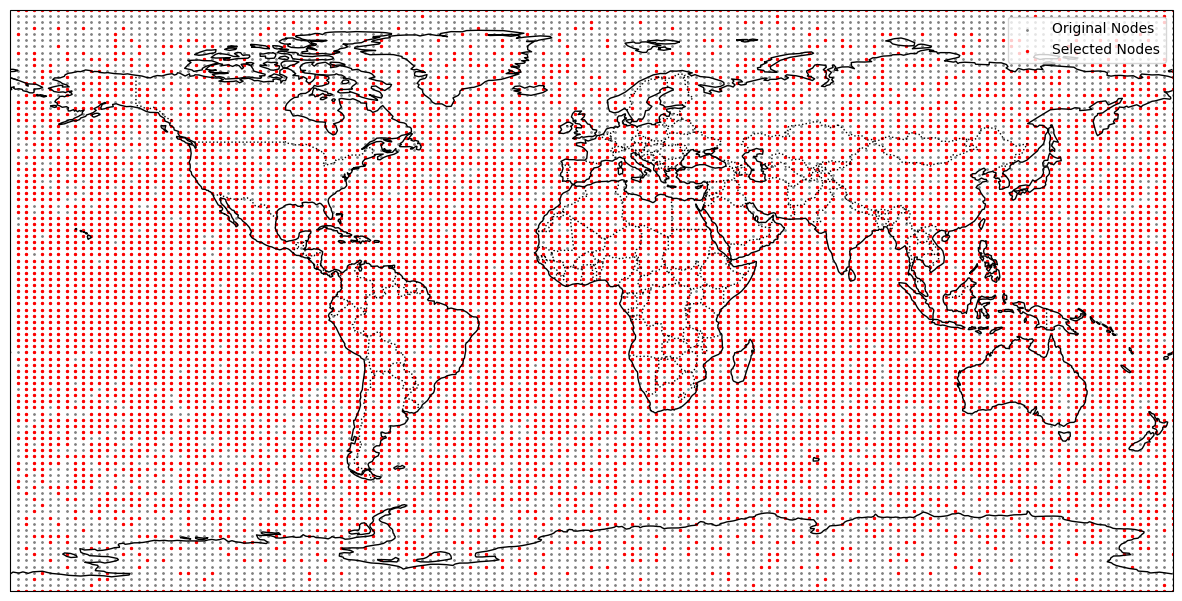

In [32]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a meshgrid of latitudes and longitudes
lons, lats = np.meshgrid(ds_sat['lon'].values, ds_sat['lat'].values)

fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot all data points in grey and label it for the legend
scatter_all = ax.scatter(lons.flatten(), lats.flatten(), color='grey', s=1, transform=ccrs.PlateCarree(), label='Original Nodes')

# Plot the sampled data points in red and label it for the legend
scatter_sampled = ax.scatter([], [], color='red', s=2, transform=ccrs.PlateCarree(), label='Selected Nodes')
for lat, lons_sampled in zip(ds_sat['lat'], chosen_lons_list):
    ax.scatter(lons_sampled, [lat]*len(lons_sampled), color='red', s=2, transform=ccrs.PlateCarree())

# Adding the legend
ax.legend(handles=[scatter_all, scatter_sampled], loc='upper right')

ax.set_global()
plt.show()


# Calculating Eigenvectors using SVD

In [34]:
import numpy as np

sat_centered_sampled=sampled_array.T

print('shape of the reshaped sat_centered_sampled:', sat_centered_sampled.shape)

u, s, vh = np.linalg.svd(sat_centered_sampled, full_matrices=True)
print('shape of u, s, vh:', u.shape, s.shape, vh.shape)



shape of the reshaped sat_centered_sampled: (8946, 65)
shape of u, s, vh: (8946, 8946) (65,) (65, 65)


# Get the first two EOFs, calculate PCs, and plot PCs

shape of EOFs: (8946, 2)
shape of PCs: (65, 2)


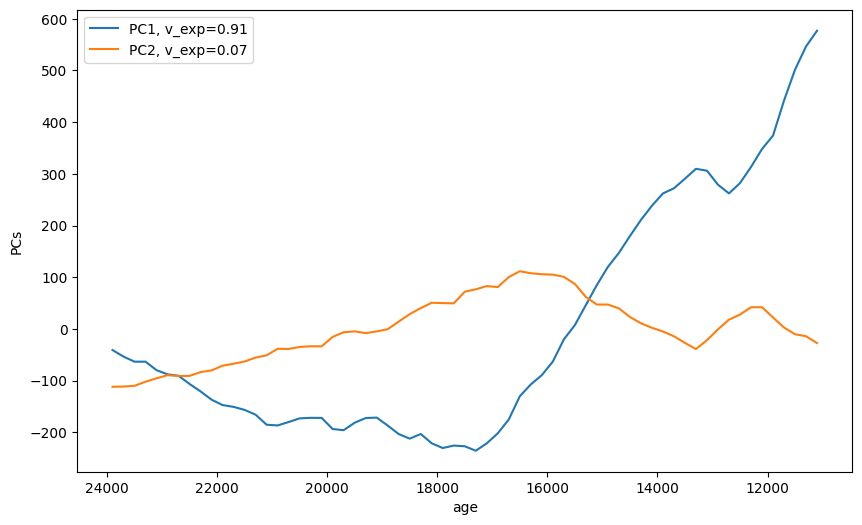

In [35]:
EOFs=u[:,0:2]
# calculate the variance explained by the first 10 PCs
variance_explained = s**2 / np.sum(s**2)

print('shape of EOFs:', EOFs.shape)
PCs=sat_centered_sampled.T.dot(EOFs)
print('shape of PCs:', PCs.shape)


# plot the PCs against the age
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(ds_sat['age'], -1*PCs[:, 0], label='PC1, v_exp={:.2f}'.format(variance_explained[0]))
ax.plot(ds_sat['age'], PCs[:, 1], label='PC2, v_exp={:.2f}'.format(variance_explained[1]))

# reverse the x-axis
ax.invert_xaxis()

ax.set_xlabel('age')
ax.set_ylabel('PCs')
ax.legend()


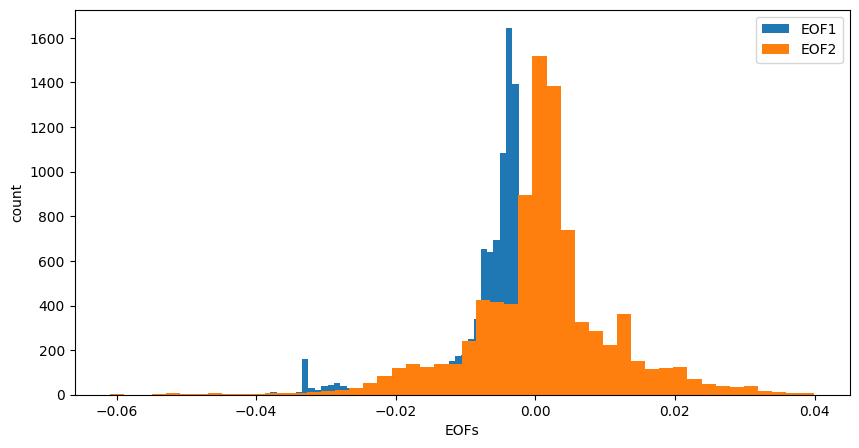

In [36]:
# plot histogram of EOFs
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(EOFs[:, 0], label='EOF1', bins=50)
ax.hist(EOFs[:, 1], label='EOF2', bins=50)

ax.set_xlabel('EOFs')
ax.set_ylabel('count')
ax.legend()

# Plot EOFs 

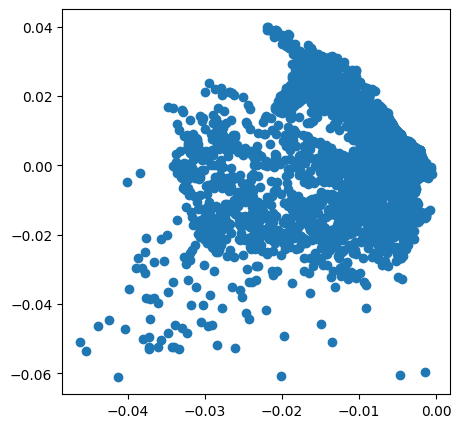

In [38]:
# plot the temp_score using 2d scatter plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(EOFs[:,0], EOFs[:,1])
plt.show()

# GMM on EOFs

In [62]:
def GMM(data, ds_sat, n_components=5):
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    gmm_model = GaussianMixture(n_components=n_components, covariance_type='full')
    gmm_model.fit(data)
    class_labels = gmm_model.predict(data)

    full_class_labels = np.full((len(ds_sat['lat']), len(ds_sat['lon'])), np.nan)
    class_label_counter = 0


    for lat_idx, (lat, lons_sampled) in enumerate(zip(ds_sat['lat'], chosen_lons_list)):
        for lon in lons_sampled:
            lon_idx = np.where(ds_sat['lon'].values == lon)[0][0]
            full_class_labels[lat_idx, lon_idx] = class_labels[class_label_counter]
            class_label_counter += 1


    ds = ds_sat.copy()
    ds['class_label'] = (('lat', 'lon'), full_class_labels)

    fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=300)

    for i in range(n_components):
        mask = class_labels == i
        ax[0].scatter(data[:, 0][mask], data[:, 1][mask], s=10, alpha=0.5, color=colors[i])

    x, y = np.meshgrid(np.linspace(np.min(data[:, 0]), np.max(data[:, 0]), 100),
                       np.linspace(np.min(data[:, 1]), np.max(data[:, 1]), 100))
    XX = np.array([x.ravel(), y.ravel()]).T
    Z = -gmm_model.score_samples(XX)
    Z = Z.reshape(x.shape)
    ax[1].contour(x, y, Z, cmap='coolwarm_r')

    ax[0].set_xlabel('EOF 1')
    ax[0].set_ylabel('EOF 2')
    ax[1].set_xlabel('EOF 1')
    ax[1].set_ylabel('EOF 2')
    ax[0].set_title('Scatter plot of loadings')
    ax[1].set_title('Contour plot of fitted GMM')

    plt.tight_layout()
    plt.show()

    return ds


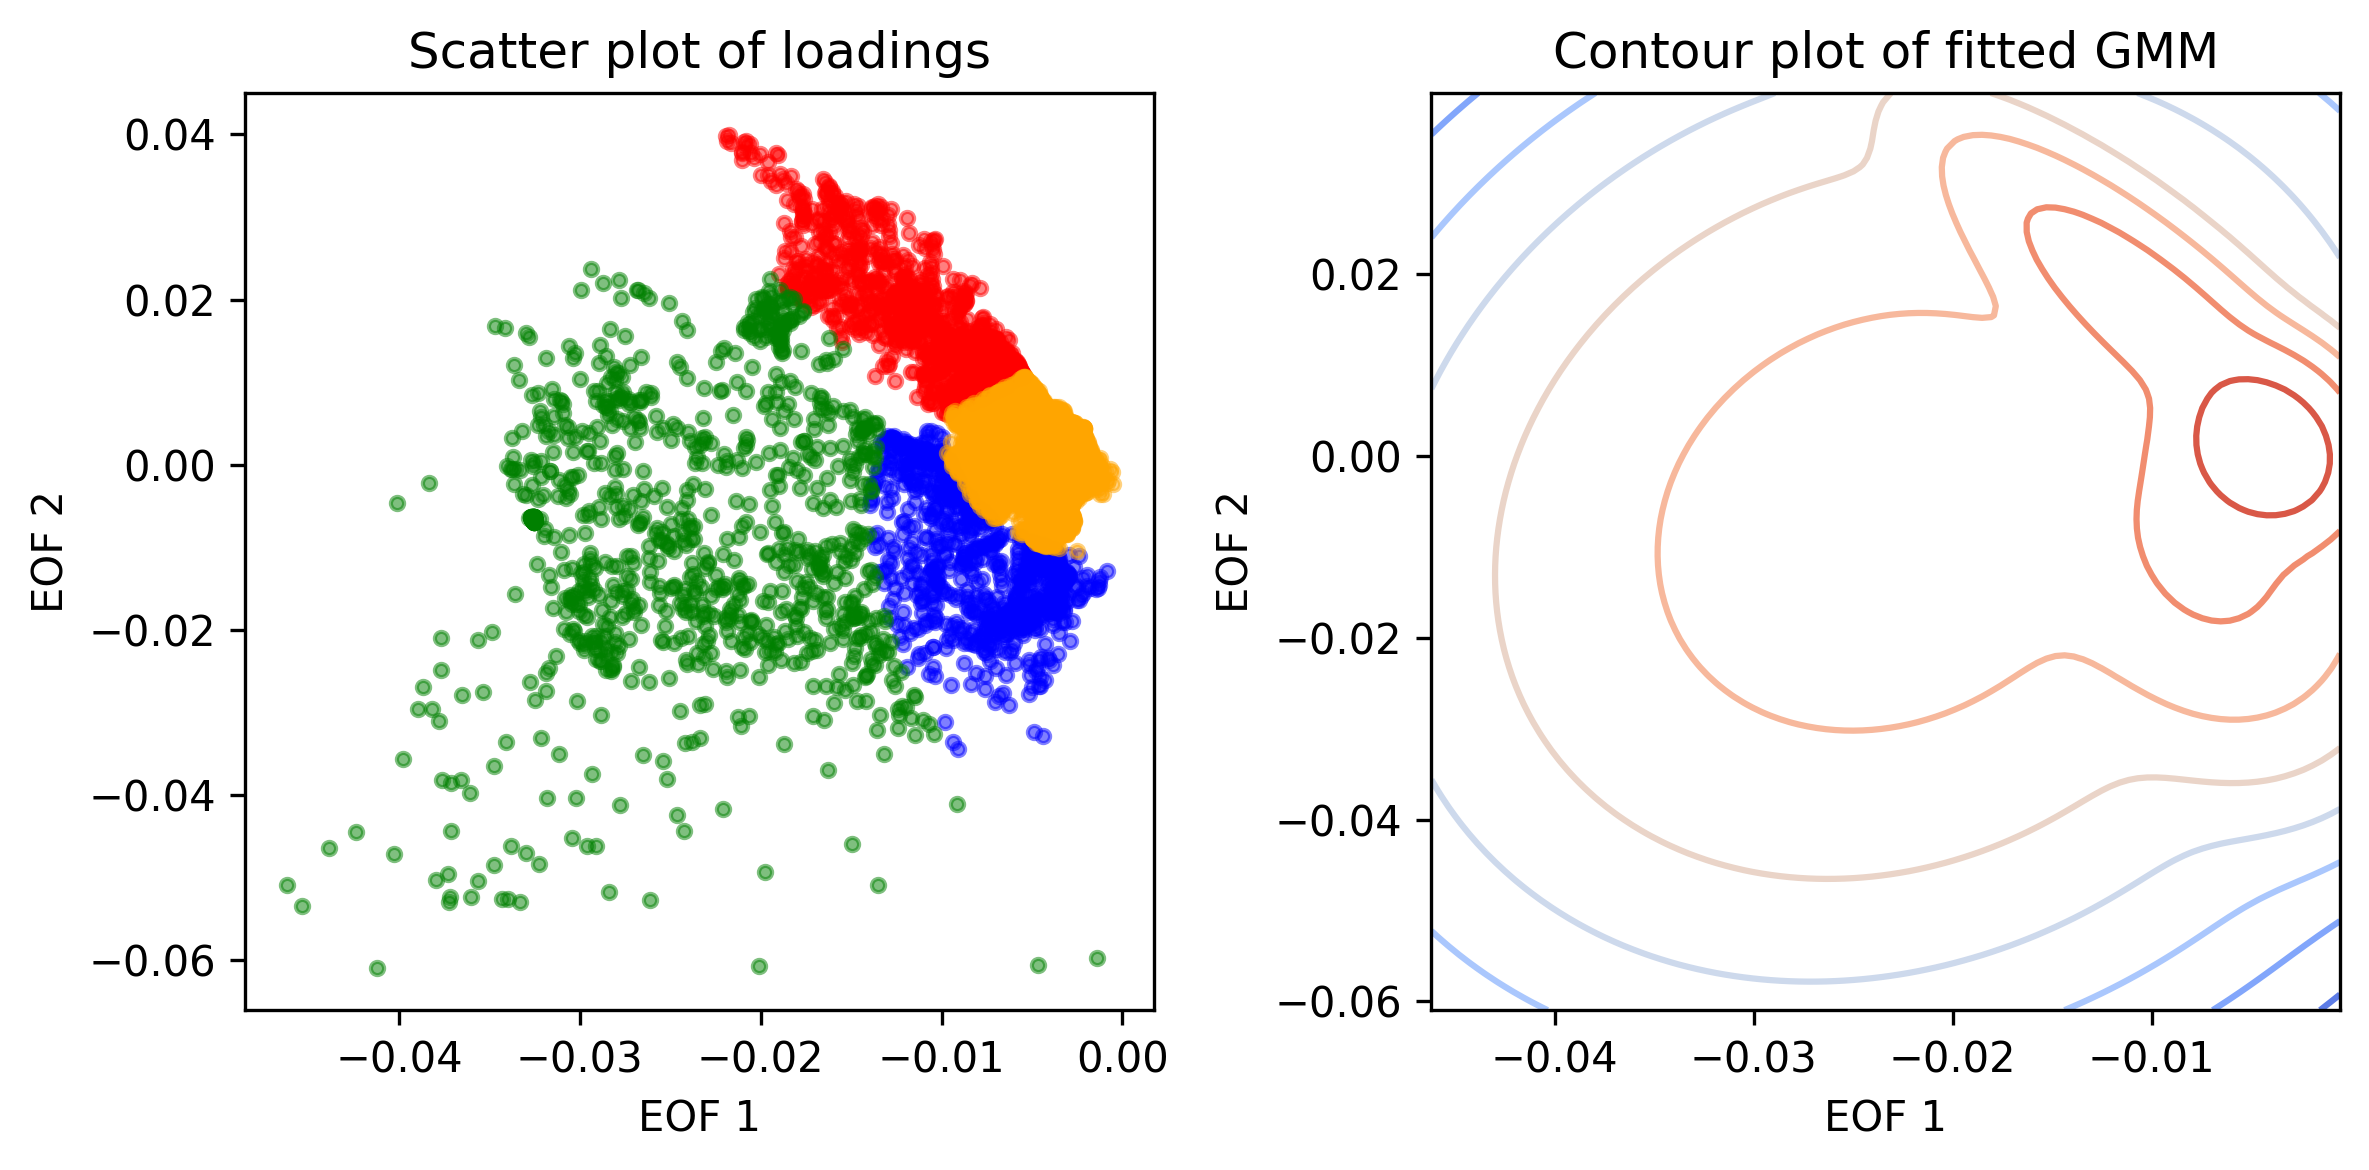

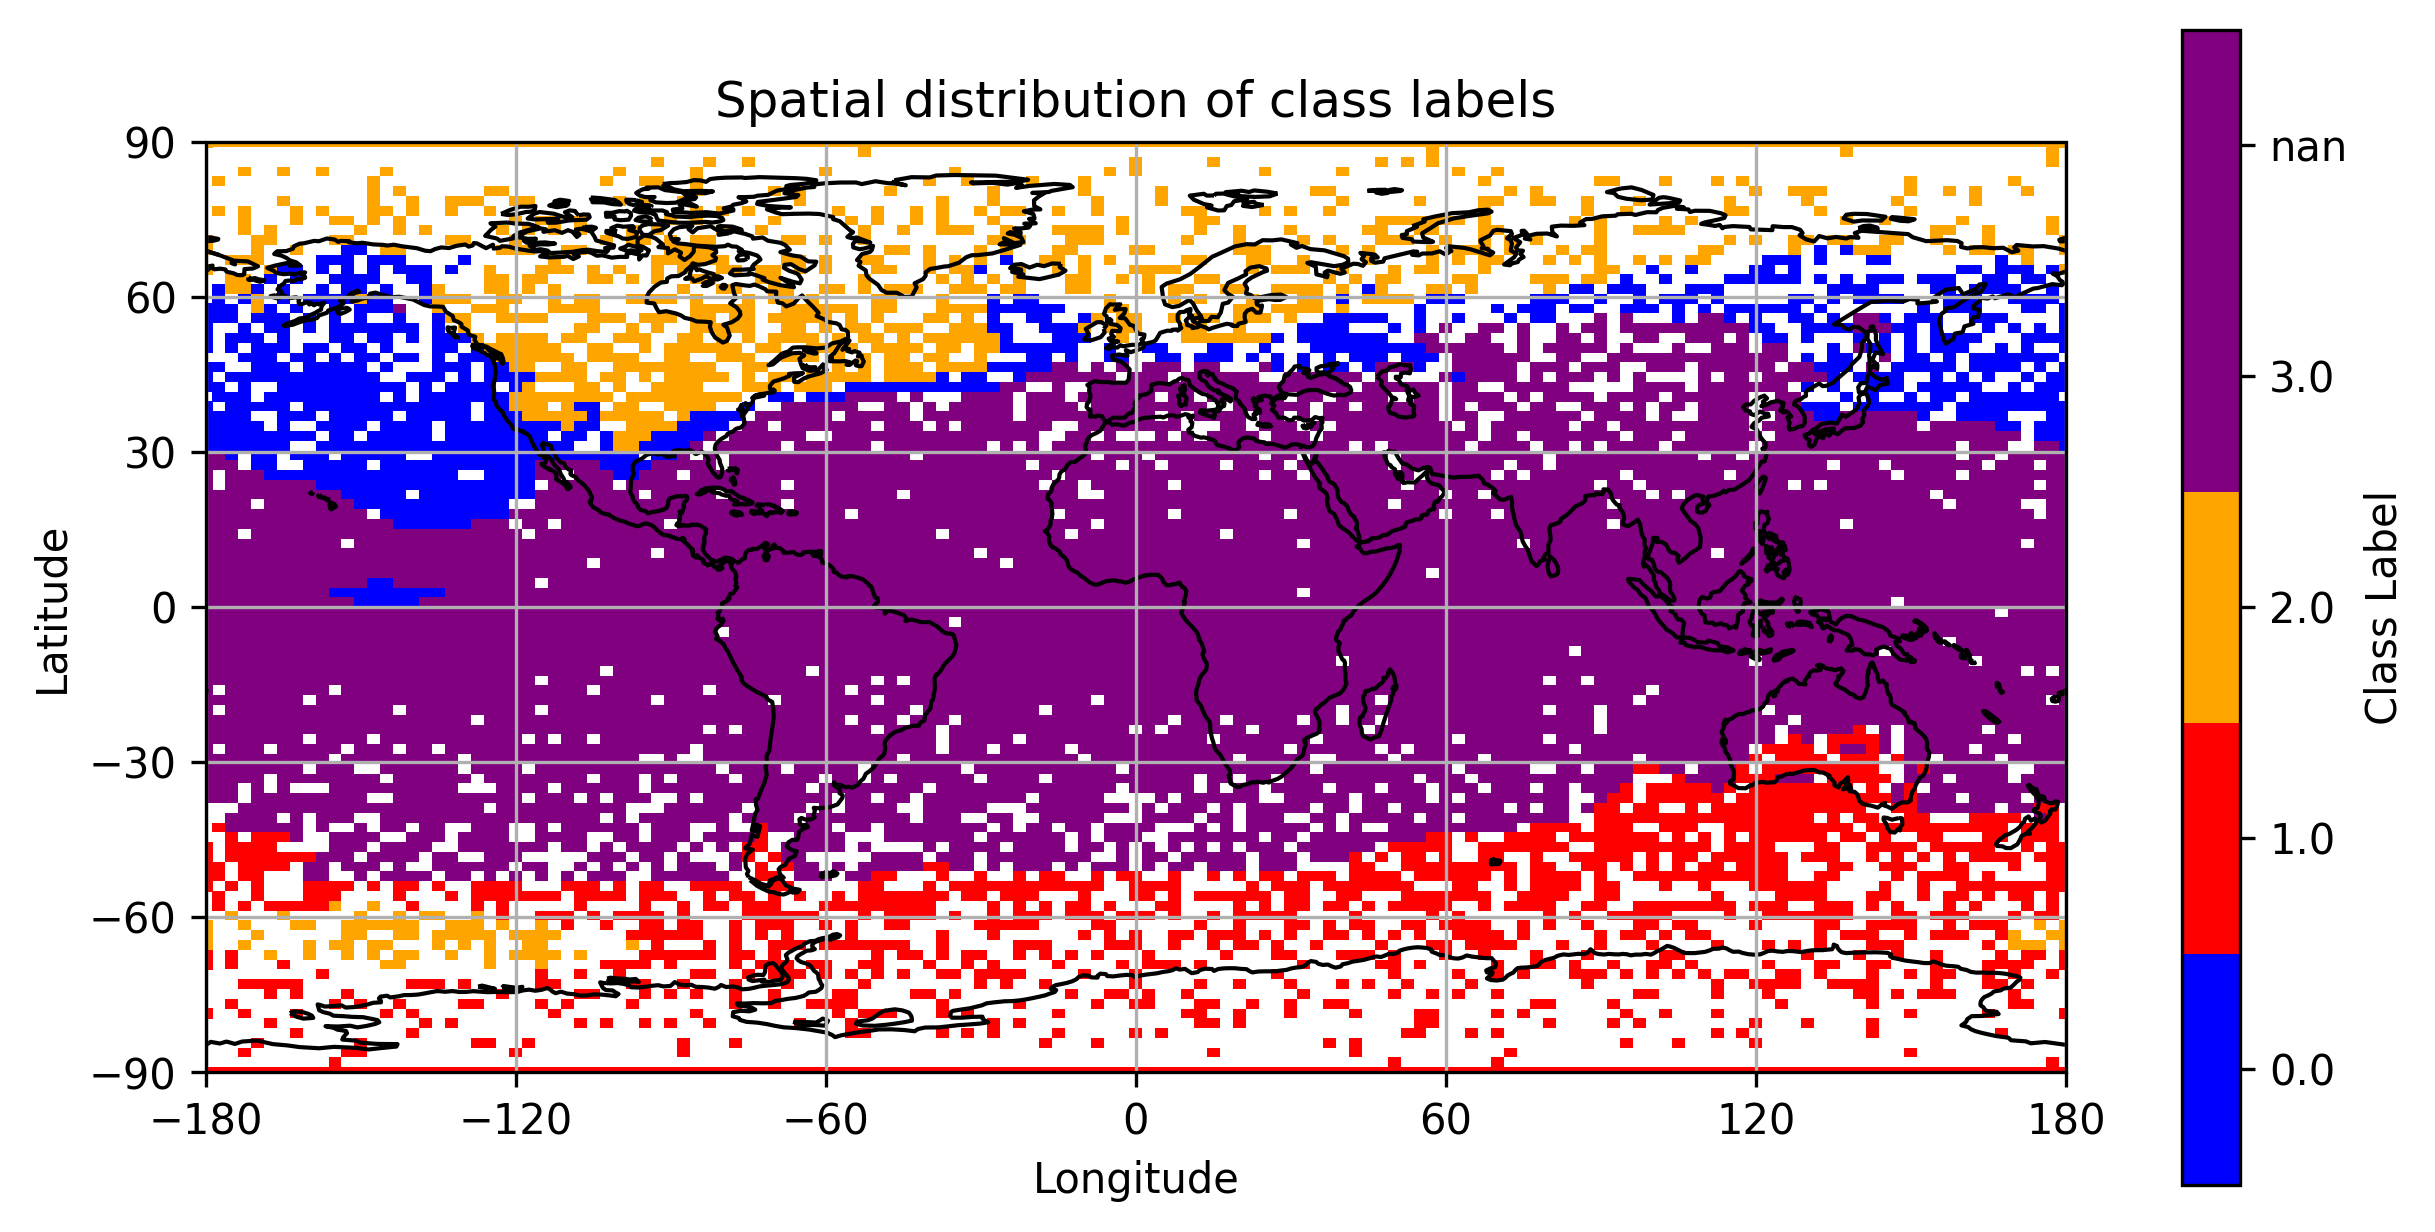

In [64]:
ds=GMM(EOFs, ds_sat,n_components=4)

from toolbox import GMM_functions as gf
gf.plot_labels(ds)